[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YOUR_GITHUB_USERNAME/YOUR_REPOSITORY_NAME/blob/main/YOUR_NOTEBOOK_PATH.ipynb)

# **alphagenomeEZ v0.9.0: Making alphagenome accessible to all**

AlphaGenomeEZ is a simplified implementation of the [google-deepmind/alphagenome](https://github.com/google-deepmind/alphagenome) meant to make the genome accessible to everyone.

For more details, see <a href="#Instructions">bottom</a> of the notebook and checkout the [AlphaGenomeEZ GitHub](https://github.com/sokrypton/ColabFold).

The offical colab notebook from [google-deepmind/alphagenome](https://colab.research.google.com/github/google-deepmind/alphagenome/blob/main/colabs/quick_start.ipynb#scrollTo=TZbfcADGkYVu)


Versions History:

Developers: [FrederickMappin](https://www.linkedin.com/in/frederick-mappin/)

Required API key can be obtained:[Get API key](https://deepmind.google.com/science/alphagenome/)


# **STEP 1. REQUIRED SET-UP**

In [ ]:
# @title Install AlphaGenome

# @markdown Run this cell to install AlphaGenome.
from IPython.display import clear_output
! pip install alphagenome
clear_output()
from alphagenome import colab_utils
from alphagenome.models import dna_client
from google.colab import data_table
import pandas as pd

In [ ]:
# @title Imports
# @markdown Import required  Libraries
from alphagenome import colab_utils
from alphagenome.data import gene_annotation
from alphagenome.data import genome
from alphagenome.data import transcript as transcript_utils
from alphagenome.interpretation import ism
from alphagenome.models import dna_client
from alphagenome.models import variant_scorers
from alphagenome.visualization import plot_components
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# @title API Key Input
# @markdown Alphagenome require API key to use. Provide key throught Google Colab Secrets Key [ALPHA_GENOME_API_KEY] or Directly.
import getpass
import os

api_key_option = "API KEY: Secrets" # @param ["API KEY: Secrets", "Enter API Key Directly"]

if api_key_option == "API KEY: Secrets":
  from google.colab import userdata
  api_key = userdata.get('ALPHA_GENOME_API_KEY')
elif api_key_option == "Enter API Key Directly":
  api_key = getpass.getpass("Enter your API Key value: ")
  os.environ["ALPHA_GENOME_API_KEY"] = api_key

dna_model = dna_client.create(api_key)

# **STEP 2. SELECT CELL OR TISSUE TYPES**

In [ ]:
# @title Find Ontology Terms of Interest

# @markdown Click Filter on the upper right hand side of the interactive dataframe and type a cell or tissue name like "brain" into the Search by all fields box to find the ontology_curie term corresponding to a tissue and output type of interest:
from alphagenome import colab_utils
from alphagenome.models import dna_client
from google.colab import data_table
import pandas as pd

output_metadata = dna_model.output_metadata(
    dna_client.Organism.HOMO_SAPIENS
).concatenate()

output_metadata

,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,data_source,endedness,genetically_modified,output_type,gtex_tissue,histone_mark,transcription_factor
0,CL:0000084 ATAC-seq,.,ATAC-seq,CL:0000084,T-cell,primary_cell,adult,encode,paired,False,OutputType.ATAC,NaN,NaN,NaN
1,CL:0000100 ATAC-seq,.,ATAC-seq,CL:0000100,motor neuron,in_vitro_differentiated_cells,adult,encode,paired,False,OutputType.ATAC,NaN,NaN,NaN
2,CL:0000236 ATAC-seq,.,ATAC-seq,CL:0000236,B cell,primary_cell,adult,encode,paired,False,OutputType.ATAC,NaN,NaN,NaN
3,CL:0000623 ATAC-seq,.,ATAC-seq,CL:0000623,natural killer cell,primary_cell,adult,encode,paired,False,OutputType.ATAC,NaN,NaN,NaN
4,CL:0000624 ATAC-seq,.,ATAC-seq,CL:0000624,"CD4-positive, alpha-beta T cell",primary_cell,adult,encode,paired,False,OutputType.ATAC,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,ENCSR182QNJ,-,PRO-cap,EFO:0001099,Caco-2,cell_line,NaN,encode,NaN,False,OutputType.PROCAP,NaN,NaN,NaN
8,ENCSR740IPL,-,PRO-cap,EFO:0002067,K562,cell_line,NaN,encode,NaN,False,OutputType.PROCAP,NaN,NaN,NaN
9,ENCSR797DEF,-,PRO-cap,EFO:0002819,Calu3,cell_line,NaN,encode,NaN,False,OutputType.PROCAP,NaN,NaN,NaN
10,ENCSR801ECP,-,PRO-cap,CL:0002618,endothelial cell of umbilical vein,primary_cell,NaN,encode,NaN,False,OutputType.PROCAP,NaN,NaN,NaN


In [ ]:
# @title Create Ontology List
# @markdown ### Enter cell or tissue types ontology_curie term (comma-separated):
cell_tissue_input = "UBERON:0001114" #@param {type:"string"}
cell_tissue_list = [item.strip() for item in cell_tissue_input.split(',') if item.strip()]

# --- Validation against output_metadata ---
print("\nValidating entered cell or tissue types against output_metadata:")
valid_cell_tissue = []
invalid_cell_tissue = []

# Assuming output_metadata DataFrame is available from a previous cell
if 'output_metadata' in locals():
    for item in cell_tissue_list:
        if (output_metadata['ontology_curie'].astype(str).str.contains(item, case=False).any() or
            output_metadata['name'].astype(str).str.contains(item, case=False).any()):
            valid_cell_tissue.append(item)
        else:
            invalid_cell_tissue.append(item)

    if valid_cell_tissue:
        print(f"Valid cell or tissue types found in metadata: {valid_cell_tissue}")
    if invalid_cell_tissue:
        print(f"Invalid cell or tissue types not found in metadata: {invalid_cell_tissue}")
    if not cell_tissue_list:
        print("No cell or tissue types entered for validation.")
else:
    print("output_metadata DataFrame not found. Cannot perform validation.")
# --- End of Validation ---


Validating entered cell or tissue types against output_metadata:
Valid cell or tissue types found in metadata: ['UBERON:0001114']







# **STEP 3. SELECT GENE OR INTERVAL**

In [ ]:
# @title Define Genomic Interval or Gene  and Resize
from alphagenome.data import genome
from alphagenome.data import gene_annotation
from alphagenome.models import dna_client
import pandas as pd

# The GTF file contains information on the location of all transcripts.
# Note that we use genome assembly hg38 for human.
gtf = pd.read_feather(
    'https://storage.googleapis.com/alphagenome/reference/gencode/'
    'hg38/gencode.v46.annotation.gtf.gz.feather'
)

# Set up transcript extractors using the information in the GTF file.
gtf_transcripts = gene_annotation.filter_protein_coding(gtf)
gtf_transcripts = gene_annotation.filter_to_longest_transcript(gtf_transcripts)
transcript_extractor = transcript_utils.TranscriptExtractor(gtf_transcripts)


#@markdown ### Choose how to define the genomic interval:
interval_definition_method = "Enter Gene Symbol" #@param ["Enter Coordinates", "Enter Gene Symbol"]

#@markdown ### Enter Interval Coordinates (if "Enter Coordinates" is selected):
chromosome = "chr1" #@param {type:"string"}
start = 500000  #@param {type:"integer"}
end = 6000000 #@param {type:"integer"}

#@markdown ### Enter Gene Symbol (if "Enter Gene Symbol" is selected):
gene_symbol = "CYP2B6" #@param {type:"string"}

#@markdown ### Select Resize Length:
resize_length_option = "SEQUENCE_LENGTH_16KB" #@param ["SEQUENCE_LENGTH_2KB", "SEQUENCE_LENGTH_16KB", "SEQUENCE_LENGTH_100KB", "SEQUENCE_LENGTH_500KB", "SEQUENCE_LENGTH_1MB"]

interval = None # Initialize interval to None

# Define the interval based on the selected method and perform initial validation
if interval_definition_method == "Enter Coordinates":
  # Basic validation for coordinates
  if not chromosome or start is None or end is None:
    print("Error: Please provide chromosome, start, and end coordinates.")
  elif start >= end:
    print("Error: Start coordinate must be less than end coordinate.")
  # Validate chromosome against GTF data
  elif chromosome not in gtf['Chromosome'].unique():
      print(f"Error: Chromosome '{chromosome}' not found in the GTF data.")
  else:
    try:
      my_interval = genome.Interval(chromosome=chromosome, start=start, end=end)
      interval = my_interval
      print(f"Coordinate interval defined: {interval}")
    except Exception as e:
      print(f"Error creating interval from coordinates: {e}")

elif interval_definition_method == "Enter Gene Symbol":
  if not gene_symbol:
    print("Error: Please provide a gene symbol.")
  else:
    try:
      interval = gene_annotation.get_gene_interval(gtf, gene_symbol=gene_symbol)
      print(f"Gene interval defined for '{gene_symbol}': {interval}")
    except ValueError:
      print(f"Error: Gene symbol '{gene_symbol}' not found in the GTF data.")
    except Exception as e:
      print(f"An unexpected error occurred while getting gene interval: {e}")


# Resize the interval based on the selected option and validate within reference
if interval is not None:
  resize_map = {
      "SEQUENCE_LENGTH_2KB": dna_client.SEQUENCE_LENGTH_2KB,
      "SEQUENCE_LENGTH_16KB": dna_client.SEQUENCE_LENGTH_16KB,
      "SEQUENCE_LENGTH_100KB": dna_client.SEQUENCE_LENGTH_100KB,
      "SEQUENCE_LENGTH_500KB": dna_client.SEQUENCE_LENGTH_500KB,
      "SEQUENCE_LENGTH_1MB": dna_client.SEQUENCE_LENGTH_1MB,
  }
  selected_resize_length = resize_map.get(resize_length_option)

  if selected_resize_length is not None:
    try:
      resized_interval = interval.resize(selected_resize_length)

      # Display the resized interval regardless of whether it's within reference
      print("Resized interval:")
      display(resized_interval)

      # Validate if the resized interval is within the reference
      if resized_interval.within_reference():
          interval = resized_interval # Keep the resized interval if it's within reference
          print("Defined and resized interval is within reference.")
          # The interval is already displayed above
      else:
          print("Error: Resized interval is NOT within the reference.")
          # You could add more details here about why it's not within reference
          # depending on the capabilities of within_reference() or by adding checks.
          interval = None # Set interval to None if not within reference

    except Exception as e:
      print(f"Error resizing or checking within reference: {e}")
      interval = None # Set interval to None if an error occurs during resizing/checking

  else:
    print(f"Invalid resize length option selected: {resize_length_option}")
else:
  print("Interval could not be defined based on the provided input, or initial validation failed.")

Gene interval defined for 'CYP2B6': chr19:40991281-41018398:+
Resized interval:


Interval(chromosome='chr19', start=40996648, end=41013032, strand='+', name='CYP2B6')

Defined and resized interval is within reference.





# **STEP 4. SELECT MODALITIES**

In [ ]:
# @title Select Modalities
# @markdown ### Select Data Types (check multiple options):
ATAC = True #@param {type:"boolean"}
CAGE = True #@param {type:"boolean"}
DNASE = True #@param {type:"boolean"}
RNA_SEQ = True #@param {type:"boolean"}
CHIP_HISTONE = True #@param {type:"boolean"}
CHIP_TF = True #@param {type:"boolean"}
SPLICE_SITES = True #@param {type:"boolean"}
SPLICE_SITE_USAGE = True #@param {type:"boolean"}
SPLICE_JUNCTIONS = True #@param {type:"boolean"}
CONTACT_MAPS = True #@param {type:"boolean"}
PROCAP = True #@param {type:"boolean"}


# Collect selected data types
selected_data_types = []
data_type_options = {
    'ATAC': ATAC,
    'CAGE': CAGE,
    'DNASE': DNASE,
    'RNA_SEQ': RNA_SEQ,
    'CHIP_HISTONE': CHIP_HISTONE,
    'CHIP_TF': CHIP_TF,
    'SPLICE_SITES': SPLICE_SITES,
    'SPLICE_SITE_USAGE': SPLICE_SITE_USAGE,
    'SPLICE_JUNCTIONS': SPLICE_JUNCTIONS,
    'CONTACT_MAPS': CONTACT_MAPS,
    'PROCAP': PROCAP
}

for data_type, selected in data_type_options.items():
    if selected:
        selected_data_types.append(data_type)

print("Selected data types:", selected_data_types)
print(f"Number of selected data types: {len(selected_data_types)}")

Selected data types: ['ATAC', 'CAGE', 'DNASE', 'RNA_SEQ', 'CHIP_HISTONE', 'CHIP_TF', 'SPLICE_SITES', 'SPLICE_SITE_USAGE', 'SPLICE_JUNCTIONS', 'CONTACT_MAPS', 'PROCAP']
Number of selected data types: 11


In [ ]:
# @title Predict Sequence (using predict_interval)

# Map selected data type strings to OutputType enums
output_type_map = {
    'ATAC': dna_client.OutputType.ATAC,
    'CAGE': dna_client.OutputType.CAGE,
    'DNASE': dna_client.OutputType.DNASE,
    'RNA_SEQ': dna_client.OutputType.RNA_SEQ,
    'CHIP_HISTONE': dna_client.OutputType.CHIP_HISTONE,
    'CHIP_TF': dna_client.OutputType.CHIP_TF,
    'SPLICE_SITES': dna_client.OutputType.SPLICE_SITES,
    'SPLICE_SITE_USAGE': dna_client.OutputType.SPLICE_SITE_USAGE,
    'SPLICE_JUNCTIONS': dna_client.OutputType.SPLICE_JUNCTIONS,
    'CONTACT_MAPS': dna_client.OutputType.CONTACT_MAPS,
    'PROCAP': dna_client.OutputType.PROCAP,
}

requested_outputs = [output_type_map[data_type] for data_type in selected_data_types if data_type in output_type_map]

# Ensure interval, valid_cell_tissue, and requested_outputs are available
if interval is None:
    print("Error: Genomic interval is not defined or valid. Please run the 'Define Genomic Interval and Resize' cell.")
elif not valid_cell_tissue:
    print("Error: No valid cell or tissue types selected. Please run the 'Create Ontology List' cell and ensure valid terms are entered.")
elif not requested_outputs:
     print("Error: No data types selected. Please run the 'Select Modalities' cell and select at least one data type.")
else:
    print(f"Requesting predictions for interval: {interval}")
    print(f"For ontology terms: {valid_cell_tissue}")
    print(f"For requested outputs: {requested_outputs}")

    output = dna_model.predict_interval(
        interval=interval,
        requested_outputs=requested_outputs,
        ontology_terms=valid_cell_tissue,
        # Assuming organism is not needed as it's handled by the interval or model
    )

    print("\nPrediction shapes:")
    # Print shapes for the requested outputs
    for data_type_str in selected_data_types:
        output_enum = output_type_map.get(data_type_str)
        if output_enum:
            # Access the prediction results using the enum name (lowercase)
            prediction_data = getattr(output, output_enum.name.lower(), None)
            if prediction_data is not None: # Check if prediction_data is not None
                  print(f'{output_enum.name} predictions shape: {prediction_data.values.shape}')

                  # Display metadata for the track
                  if hasattr(prediction_data, 'metadata'):
                      print(f'{output_enum.name} metadata:')
                      display(prediction_data.metadata)
                  else:
                      print(f'No metadata found for {output_enum.name}')

            else:
                 print(f'Could not find prediction data for {output_enum.name}')
        else:
            print(f'Unknown selected data type: {data_type_str}')

Requesting predictions for interval: chr19:40996648-41013032:+
For ontology terms: ['UBERON:0001114']
For requested outputs: [ATAC, CAGE, DNASE, RNA_SEQ, CHIP_HISTONE, CHIP_TF, SPLICE_SITES, SPLICE_SITE_USAGE, SPLICE_JUNCTIONS, CONTACT_MAPS, PROCAP]

Prediction shapes:
ATAC predictions shape: (16384, 1)
ATAC metadata:


,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,data_source,endedness,genetically_modified
0,UBERON:0001114 ATAC-seq,.,ATAC-seq,UBERON:0001114,right lobe of liver,tissue,adult,encode,paired,False


CAGE predictions shape: (16384, 0)
CAGE metadata:


,name,strand


DNASE predictions shape: (16384, 1)
DNASE metadata:


,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,data_source,endedness,genetically_modified
0,UBERON:0001114 DNase-seq,.,DNase-seq,UBERON:0001114,right lobe of liver,tissue,adult,encode,paired,False


RNA_SEQ predictions shape: (16384, 3)
RNA_SEQ metadata:


,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,gtex_tissue,data_source,endedness,genetically_modified
0,UBERON:0001114 total RNA-seq,+,total RNA-seq,UBERON:0001114,right lobe of liver,tissue,adult,,encode,paired,False
1,UBERON:0001114 total RNA-seq,-,total RNA-seq,UBERON:0001114,right lobe of liver,tissue,adult,,encode,paired,False
2,UBERON:0001114 gtex Liver polyA plus RNA-seq,.,polyA plus RNA-seq,UBERON:0001114,right lobe of liver,tissue,adult,Liver,gtex,paired,False


CHIP_HISTONE predictions shape: (128, 4)
CHIP_HISTONE metadata:


,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,histone_mark,data_source,endedness,genetically_modified
0,UBERON:0001114 Histone ChIP-seq H3K27ac,.,Histone ChIP-seq,UBERON:0001114,right lobe of liver,tissue,adult,H3K27ac,encode,single,False
1,UBERON:0001114 Histone ChIP-seq H3K36me3,.,Histone ChIP-seq,UBERON:0001114,right lobe of liver,tissue,adult,H3K36me3,encode,single,False
2,UBERON:0001114 Histone ChIP-seq H3K4me1,.,Histone ChIP-seq,UBERON:0001114,right lobe of liver,tissue,adult,H3K4me1,encode,single,False
3,UBERON:0001114 Histone ChIP-seq H3K4me3,.,Histone ChIP-seq,UBERON:0001114,right lobe of liver,tissue,adult,H3K4me3,encode,single,False


CHIP_TF predictions shape: (128, 2)
CHIP_TF metadata:


,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,transcription_factor,data_source,endedness,genetically_modified
0,UBERON:0001114 TF ChIP-seq CTCF,.,TF ChIP-seq,UBERON:0001114,right lobe of liver,tissue,adult,CTCF,encode,paired,False
1,UBERON:0001114 TF ChIP-seq POLR2A,.,TF ChIP-seq,UBERON:0001114,right lobe of liver,tissue,adult,POLR2A,encode,paired,False


SPLICE_SITES predictions shape: (16384, 4)
SPLICE_SITES metadata:


,name,strand
0,donor,+
1,acceptor,+
2,donor,-
3,acceptor,-


SPLICE_SITE_USAGE predictions shape: (16384, 4)
SPLICE_SITE_USAGE metadata:


,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,gtex_tissue,data_source
0,usage_UBERON:0001114 gtex Liver polyA plus RNA...,+,polyA plus RNA-seq,UBERON:0001114,right lobe of liver,tissue,adult,Liver,gtex
1,usage_UBERON:0001114 total RNA-seq,+,total RNA-seq,UBERON:0001114,right lobe of liver,tissue,adult,,encode
2,usage_UBERON:0001114 gtex Liver polyA plus RNA...,-,polyA plus RNA-seq,UBERON:0001114,right lobe of liver,tissue,adult,Liver,gtex
3,usage_UBERON:0001114 total RNA-seq,-,total RNA-seq,UBERON:0001114,right lobe of liver,tissue,adult,,encode


SPLICE_JUNCTIONS predictions shape: (48, 2)
SPLICE_JUNCTIONS metadata:


,name,ontology_curie,biosample_name,biosample_type,gtex_tissue
0,junction_UBERON:0001114 gtex Liver polyA plus ...,UBERON:0001114,right lobe of liver,tissue,Liver
1,junction_UBERON:0001114 total RNA-seq,UBERON:0001114,right lobe of liver,tissue,


CONTACT_MAPS predictions shape: (8, 8, 0)
CONTACT_MAPS metadata:


,name,strand


PROCAP predictions shape: (16384, 0)
PROCAP metadata:


,name,strand


# **STEP 5. VISUALIZE**

Extracted 1 transcripts in this interval.

Plotting interval: chr19:41001973-41007707


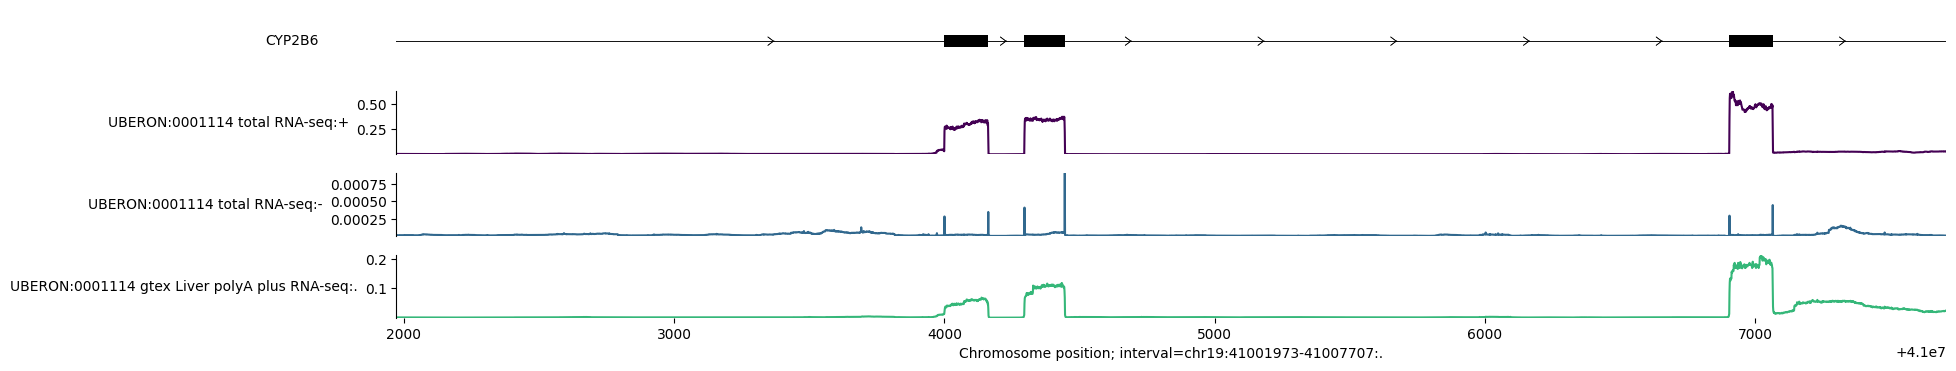

In [ ]:
# @title Visualize Transcripts and Predicted Tracks
import matplotlib.pyplot as plt
from alphagenome.visualization import plot_components
from alphagenome.data import genome # Import genome module to create new intervals

longest_transcripts = transcript_extractor.extract(interval)
print(f'Extracted {len(longest_transcripts)} transcripts in this interval.')

# Set max plot resize length to the width of the predicted interval (first dimension of shape)
max_plot_resize_length = output.rna_seq.values.shape[0]

#@markdown ### Select the zoom level (slide from 0 to 100%):
zoom_percentage = 35 #@param {type:"slider", min:0, max:100, step:1}

# Calculate the plot resize length based on the zoom percentage
# Ensure we don't divide by zero if max_plot_resize_length is 0 (though unlikely)
if max_plot_resize_length > 0:
    plot_resize_length = int((zoom_percentage / 100.0) * max_plot_resize_length)
else:
    plot_resize_length = 0 # Or handle this case as appropriate

# Ensure plot_resize_length is at least 1 for plotting purposes if max length is > 0
if plot_resize_length == 0 and max_plot_resize_length > 0:
    plot_resize_length = 1
elif max_plot_resize_length == 0:
    print("Warning: Predicted interval length is 0, cannot create plot.")
    plot_resize_length = 0 # Cannot plot if interval length is 0


# Create a new interval for plotting, centered within the predicted interval
# Only proceed if plot_resize_length is greater than 0
if plot_resize_length > 0:
    predicted_interval = output.rna_seq.interval
    center = (predicted_interval.start + predicted_interval.end) // 2
    plot_start = center - plot_resize_length // 2
    plot_end = center + (plot_resize_length - plot_resize_length // 2) # Handle odd lengths

    # Ensure the new plot interval is within the bounds of the predicted interval
    plot_start = max(plot_start, predicted_interval.start)
    plot_end = min(plot_end, predicted_interval.end)

    # Create the plotting interval object (still needed for the plot function)
    plotting_interval = genome.Interval(
        chromosome=predicted_interval.chromosome,
        start=plot_start,
        end=plot_end,
        strand=predicted_interval.strand,
        name=predicted_interval.name # Keep the name if it exists
    )

    # Print the details of the plotting interval using plot_start and plot_end
    print(f"\nPlotting interval: {predicted_interval.chromosome}:{plot_start}-{plot_end}")


    plot_components.plot(
        components=[
            plot_components.TranscriptAnnotation(
                longest_transcripts, fig_height=0.1
            ),
            plot_components.Tracks(output.rna_seq),
        ],
        interval=plotting_interval, # Use the newly created plotting interval
    )

    plt.show()
else:
    print("Plot not generated because plot_resize_length is 0.") # Message if plot length is 0